In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'. Same as before
application_df.drop(columns=['EIN', 'NAME'], inplace=True)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# The status = 0 seems useless, so we might as well remove it.
#display(application_df['STATUS'].value_counts())

# 1. full T/F DF of if status == 0
# application_df['STATUS'] == 0
# 2. get subset of entire DF for when status == 0
# application_df.loc[application_df['STATUS'] == 0]
# 3. get a list of these index values
# application_df.loc[application_df['STATUS'] == 0].index
# 4. drop those index values from the above list. use .info() to test if they drop
# application_df.drop(index=application_df.loc[application_df['STATUS'] == 0].index).info()
# sucessfully dropped, so lets apply it. store it as new df, step1_df

step1_df = application_df.drop(index=application_df.loc[application_df['STATUS'] == 0].index)

#reset index so it isn't mising any values
step1_df.reset_index(inplace=True, drop=True)

# drop status column since it is now superfluous
step1_df.drop(columns=["STATUS"], inplace=True)

step1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34294 entries, 0 to 34293
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34294 non-null  object
 1   AFFILIATION             34294 non-null  object
 2   CLASSIFICATION          34294 non-null  object
 3   USE_CASE                34294 non-null  object
 4   ORGANIZATION            34294 non-null  object
 5   INCOME_AMT              34294 non-null  object
 6   SPECIAL_CONSIDERATIONS  34294 non-null  object
 7   ASK_AMT                 34294 non-null  int64 
 8   IS_SUCCESSFUL           34294 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 2.4+ MB


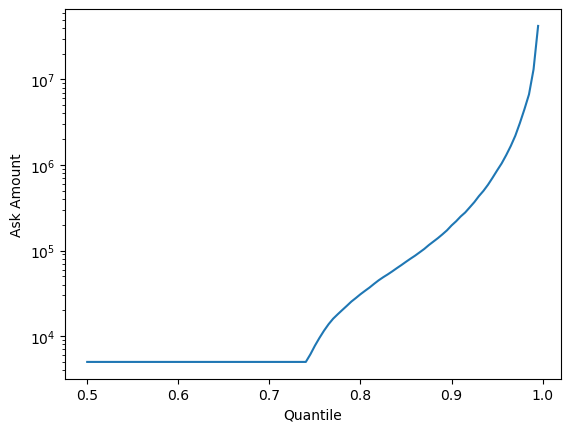

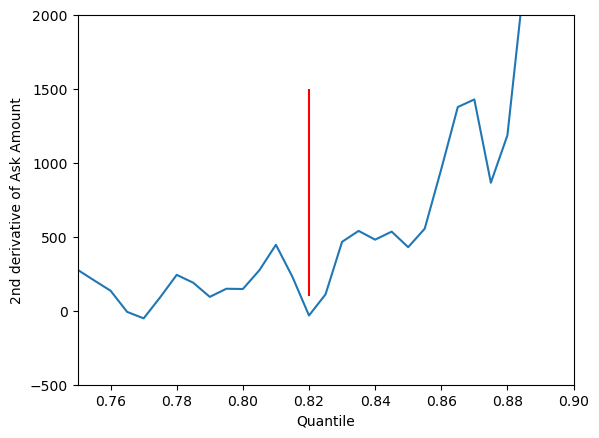

44963.839999999946


In [5]:
# Take a look at the statistics for the ASK_AMT
#display(step1_df.describe())
# >34k rows
# Min = 5k. 1st quartile = 5k. 2nd quartile = 5k. 3rd quartile = 7.7k. max = 8.5b
# IQR = 2.7k. 1.5*IQR = 4.05k. 1.5*IQR+3rdQ ~ 12k

#step1_df.loc[step1_df['ASK_AMT'] > 12000].describe()
# 8200 rows
# Min = 12k. 1st quartile = 45k. 2nd quartile = 128k. 3rd quartile = 600k. max = 8.5b
# IQR = 450k. 1.5*IQR = 675k. 1.5*IQR+3rdQ ~ 1.3m

#step1_df.loc[step1_df['ASK_AMT'] > 1300000].describe()
# 1400 rows still above 1.3m
# Min = 1.3m. 1st quartile = 2.2m. 2nd quartile = 4.5m. 3rd quartile = 13m. max = 8.5b
# IQR = 11m. 1.5*IQR = 16.5m. 1.5*IQR+3rdQ ~ 30m

#step1_df.loc[step1_df['ASK_AMT'] > 30e6].describe()
#224 rows above this number

# 

step1_df['ASK_AMT'].quantile(np.asarray(range(500, 1000, 5))/1000).plot()
plt.yscale("log")
plt.xlabel("Quantile")
plt.ylabel("Ask Amount")
plt.show()

#plt.plot(step1_df['ASK_AMT'].quantile(np.asarray(range(500, 1000, 5))/1000).index, np.gradient(step1_df['ASK_AMT'].quantile(np.asarray(range(500, 1000, 5))/1000).values))
plt.plot(step1_df['ASK_AMT'].quantile(np.asarray(range(500, 1000, 5))/1000).index, np.gradient(np.gradient(step1_df['ASK_AMT'].quantile(np.asarray(range(500, 1000, 5))/1000).values)))
plt.ylim(-0.5e3,0.2e4)
plt.xlim(0.75, 0.9)
plt.xlabel("Quantile")
plt.ylabel("2nd derivative of Ask Amount")
plt.vlines(0.82, 100, 1500, 'r')
plt.show()

# # we can see inflection point at 82nd percentile
# # throw out everything above 82nd percentile
cutoff82nd = step1_df['ASK_AMT'].quantile([0.82]).values[0]
print(cutoff82nd)

In [6]:
# step back a second
# are the large-funding requests spread evenly across application types and classifications?

#step1_df.groupby("APPLICATION_TYPE")['ASK_AMT'].describe()

#step1_df.groupby("CLASSIFICATION")['ASK_AMT'].describe()
# to see *all* of them at once:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(step1_df.groupby("CLASSIFICATION")['ASK_AMT'].describe())

# looks like mostly yes. so we don't need to exclude a certain type of application type / classification

In [7]:
# create 2 new dataframes, each excluding values above the cutoff82nd. one from application_df and one from step1_df.
# use drop like above, reset indices

inliers_df = application_df.drop(index=application_df.loc[application_df["ASK_AMT"] > cutoff82nd].index)
inliers_df.reset_index(inplace=True, drop=True)

step1inliers_df = step1_df.drop(index=step1_df.loc[step1_df['ASK_AMT'] > cutoff82nd].index)
step1inliers_df.reset_index(inplace=True, drop=True)

display(step1_df.info())
display(inliers_df.info())
display(step1inliers_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34294 entries, 0 to 34293
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34294 non-null  object
 1   AFFILIATION             34294 non-null  object
 2   CLASSIFICATION          34294 non-null  object
 3   USE_CASE                34294 non-null  object
 4   ORGANIZATION            34294 non-null  object
 5   INCOME_AMT              34294 non-null  object
 6   SPECIAL_CONSIDERATIONS  34294 non-null  object
 7   ASK_AMT                 34294 non-null  int64 
 8   IS_SUCCESSFUL           34294 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 2.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28126 entries, 0 to 28125
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        28126 non-null  object
 1   AFFILIATION             28126 non-null  object
 2   CLASSIFICATION          28126 non-null  object
 3   USE_CASE                28126 non-null  object
 4   ORGANIZATION            28126 non-null  object
 5   STATUS                  28126 non-null  int64 
 6   INCOME_AMT              28126 non-null  object
 7   SPECIAL_CONSIDERATIONS  28126 non-null  object
 8   ASK_AMT                 28126 non-null  int64 
 9   IS_SUCCESSFUL           28126 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28121 entries, 0 to 28120
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        28121 non-null  object
 1   AFFILIATION             28121 non-null  object
 2   CLASSIFICATION          28121 non-null  object
 3   USE_CASE                28121 non-null  object
 4   ORGANIZATION            28121 non-null  object
 5   INCOME_AMT              28121 non-null  object
 6   SPECIAL_CONSIDERATIONS  28121 non-null  object
 7   ASK_AMT                 28121 non-null  int64 
 8   IS_SUCCESSFUL           28121 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 1.9+ MB


None

In [8]:
# binning application type

# for each of our DFs, step1_df, inliers_df, step1inliers_df, apply 2 binning methods.
# 1: as before, combine T9, T13, T12, T2, T25, T14, T29, T15, T17 into 'other'
# 2: combine combine T9, T13, T12, T2, T25, T14, T29, T15, T17, and T10 into 'other'
#      (option 1 from earlier)
# don't want binary option

# step1_df -> step1prevT_df will use previous binning
# step1_df -> step1newT_df will use new binning
step1prevT_df = step1_df.replace(to_replace=['T9', 'T13', 'T12', 'T2', 'T25', 'T14', 'T29', 'T15', 'T17'],
                                value=['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
                               )
step1newT_df = step1_df.replace(to_replace=['T9', 'T13', 'T12', 'T2', 'T25', 'T14', 'T29', 'T15', 'T17', 'T10'],
                                value=['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
                               )

# step1inliers_df -> step1inliersprevT_df will use previous binning
# step1inliers_df -> step1inliersnewT_df will use new binning
step1inliersprevT_df = step1inliers_df.replace(to_replace=['T9', 'T13', 'T12', 'T2', 'T25', 'T14', 'T29', 'T15', 'T17'],
                                value=['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
                               )
step1inliersnewT_df = step1inliers_df.replace(to_replace=['T9', 'T13', 'T12', 'T2', 'T25', 'T14', 'T29', 'T15', 'T17', 'T10'],
                                value=['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
                               )

# inliers_df -> inliersprevT_df will use previous binning
# inliers_df -> inliersnewT_df will use new binning
inliersprevT_df = inliers_df.replace(to_replace=['T9', 'T13', 'T12', 'T2', 'T25', 'T14', 'T29', 'T15', 'T17'],
                                value=['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
                               )
inliersnewT_df = inliers_df.replace(to_replace=['T9', 'T13', 'T12', 'T2', 'T25', 'T14', 'T29', 'T15', 'T17', 'T10'],
                                value=['Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
                               )


In [9]:
# binning classification values

# from previous discussion, keep C1000 separate from C1[^0]xx
# combine C4xxx-C8xxx into singular bin, Cother
# include C0 in Cother

# works: 
# application_df["CLASSIFICATION"]\
#     .replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C4\d{3}', 'C5\d{3}', 'C6\d{3}', 'C7\d{3}', 'C8\d{3}'],
#              ['C1xxx', 'C2xxx', 'C3xxx', 'C4xxx', 'C5xxx', 'C6xxx', 'C7xxx', 'C8xxx'], regex=True)\
#     .value_counts()


#testing
# step1_df["CLASSIFICATION"]\
#     .replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C[4-8]\d{3}', 'C0'],
#              ['C1xxx', 'C2xxx', 'C3xxx', 'Cother', 'Cother'], regex=True)\
#     .value_counts()

# DFs: (move to abbreviations)
# step1prevT_df -> s1pTpC_df, s1pTnC_df  = (s)tep(1)(p)rev(T)[(p)rev/(n)ew]C
# step1newT_df -> s1nTpC_df, s1nTnC_df   = (s)tep(1)(n)ew(T)[(p)rev/(n)ew]C
# step1inliersprevT_df -> s1ilpTpC_df, s1ilpTnC_df = (s)tep(1)(i)n(l)iers(p)rev(T)[(p)rev/(n)ew]C
# step1inliersnewT_df -> s1ilnTpC_df, s1ilnTnC_df  = (s)tep(1)(i)n(l)iers(n)ew(T)[(p)rev/(n)ew]C
# inliersprevT_df -> ilpTpC_df, ilpTnC_df  = (i)n(l)iers(p)rev(T)[(p)rev/(n)ew]C
# inliersnewT_df -> ilnTpC_df, ilnTnC      = (i)n(l)iers(n)ew(T)[(p)rev/(n)ew]C


# s1pT
s1pTpC_df = step1prevT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C4\d{3}', 'C5\d{3}', 'C6\d{3}', 'C7\d{3}', 'C8\d{3}'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'C4xxx', 'C5xxx', 'C6xxx', 'C7xxx', 'C8xxx'], regex=True)
s1pTnC_df = step1prevT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C[4-8]\d{3}', 'C0'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'Cother', 'Cother'], regex=True)

# s1nT
s1nTpC_df = step1newT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C4\d{3}', 'C5\d{3}', 'C6\d{3}', 'C7\d{3}', 'C8\d{3}'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'C4xxx', 'C5xxx', 'C6xxx', 'C7xxx', 'C8xxx'], regex=True)
s1nTnC_df = step1newT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C[4-8]\d{3}', 'C0'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'Cother', 'Cother'], regex=True)

# s1ilpT
s1ilpTpC_df = step1inliersprevT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C4\d{3}', 'C5\d{3}', 'C6\d{3}', 'C7\d{3}', 'C8\d{3}'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'C4xxx', 'C5xxx', 'C6xxx', 'C7xxx', 'C8xxx'], regex=True)
s1ilpTnC_df = step1inliersprevT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C[4-8]\d{3}', 'C0'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'Cother', 'Cother'], regex=True)

# s1ilnT
s1ilnTpC_df = step1inliersnewT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C4\d{3}', 'C5\d{3}', 'C6\d{3}', 'C7\d{3}', 'C8\d{3}'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'C4xxx', 'C5xxx', 'C6xxx', 'C7xxx', 'C8xxx'], regex=True)
s1ilnTnC_df = step1inliersnewT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C[4-8]\d{3}', 'C0'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'Cother', 'Cother'], regex=True)

# ilpT
ilpTpC_df = inliersprevT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C4\d{3}', 'C5\d{3}', 'C6\d{3}', 'C7\d{3}', 'C8\d{3}'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'C4xxx', 'C5xxx', 'C6xxx', 'C7xxx', 'C8xxx'], regex=True)
ilpTnC_df = inliersprevT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C[4-8]\d{3}', 'C0'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'Cother', 'Cother'], regex=True)

# ilnT
ilnTpC_df = inliersnewT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C4\d{3}', 'C5\d{3}', 'C6\d{3}', 'C7\d{3}', 'C8\d{3}'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'C4xxx', 'C5xxx', 'C6xxx', 'C7xxx', 'C8xxx'], regex=True)
ilnTnC_df = inliersnewT_df.replace(['C1[^0]\d{2}', 'C2\d{3}', 'C3\d{3}', 'C[4-8]\d{3}', 'C0'],
                                  ['C1xxx', 'C2xxx', 'C3xxx', 'Cother', 'Cother'], regex=True)


In [10]:
# let's look at classification value counts

print("s1, prevT, prevC\n", s1pTpC_df['CLASSIFICATION'].value_counts())
print("s1, prevT, newC\n", s1pTnC_df['CLASSIFICATION'].value_counts())
print("s1, newT, prevC\n", s1nTpC_df['CLASSIFICATION'].value_counts())
print("s1, newT, newC\n", s1nTnC_df['CLASSIFICATION'].value_counts())

print("s1, inliers, prevT, prevC\n", s1ilpTpC_df['CLASSIFICATION'].value_counts())
print("s1, inliers, prevT, newC\n", s1ilpTnC_df['CLASSIFICATION'].value_counts())
print("s1, inliers, newT, prevC\n", s1ilnTpC_df['CLASSIFICATION'].value_counts())
print("s1, inliers, newT, newC\n", s1ilnTnC_df['CLASSIFICATION'].value_counts())

print("inliers, prevT, prevC\n", ilpTpC_df['CLASSIFICATION'].value_counts())
print("inliers, prevT, newC\n", ilpTnC_df['CLASSIFICATION'].value_counts())
print("inliers, newT, prevC\n", ilnTpC_df['CLASSIFICATION'].value_counts())
print("inliers, newT, newC\n", ilnTnC_df['CLASSIFICATION'].value_counts())

#print(ilnTnC_df['CLASSIFICATION'].value_counts())

s1, prevT, prevC
 C1000    17323
C2xxx     8203
C1xxx     5567
C3xxx     1921
C7xxx      909
C4xxx      203
C5xxx      117
C8xxx       32
C6xxx       16
C0           3
Name: CLASSIFICATION, dtype: int64
s1, prevT, newC
 C1000     17323
C2xxx      8203
C1xxx      5567
C3xxx      1921
Cother     1280
Name: CLASSIFICATION, dtype: int64
s1, newT, prevC
 C1000    17323
C2xxx     8203
C1xxx     5567
C3xxx     1921
C7xxx      909
C4xxx      203
C5xxx      117
C8xxx       32
C6xxx       16
C0           3
Name: CLASSIFICATION, dtype: int64
s1, newT, newC
 C1000     17323
C2xxx      8203
C1xxx      5567
C3xxx      1921
Cother     1280
Name: CLASSIFICATION, dtype: int64
s1, inliers, prevT, prevC
 C1000    13641
C2xxx     6950
C1xxx     4864
C3xxx     1647
C7xxx      716
C4xxx      154
C5xxx      109
C8xxx       23
C6xxx       15
C0           2
Name: CLASSIFICATION, dtype: int64
s1, inliers, prevT, newC
 C1000     13641
C2xxx      6950
C1xxx      4864
C3xxx      1647
Cother     1019
Name: CLASSIFI

In [14]:
# DFs: (posted to keep them straight)
# s1pTpC_df, s1pTnC_df, s1nTpC_df, s1nTnC_df, s1ilpTpC_df, s1ilpTnC_df, s1ilnTpC_df, s1ilnTnC_df
# ilpTpC_df, ilpTnC_df, ilnTpC_df, ilnTnC_df

# time to one hot encode the categorical variables

# double check categorical column names are the same to make sure nothing broke
# s1pTpC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# s1pTnC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# s1nTpC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# s1nTnC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# s1ilpTpC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# s1ilpTnC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# s1ilnTpC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# s1ilnTnC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# ilpTpC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# ilpTnC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# ilnTpC_df.dtypes[application_df.dtypes=='object'].index.to_list() == \
# ilnTnC_df.dtypes[application_df.dtypes=='object'].index.to_list()
# True

# now we can use just a single list of categorical variables
cat_feats = s1ilnTnC_df.dtypes[application_df.dtypes=='object'].index.to_list()
cat_feats


['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [16]:
# DFs: (posted to keep them straight)
# s1pTpC_df, s1pTnC_df, s1nTpC_df, s1nTnC_df, s1ilpTpC_df, s1ilpTnC_df, s1ilnTpC_df, s1ilnTnC_df
# ilpTpC_df, ilpTnC_df, ilnTpC_df, ilnTnC_df

# make encoder
# fit_transform and immediately transform into new DF
# merge with DF

# tmpEnc = pd.DataFrame(enc.fit_transform(application_df[cat_feats]),
#                          columns=enc.get_feature_names_out())
# final_df = application_df.merge(tmpEnc_df, left_index=True, right_index=True).drop(columns=cat_feats)

# s1pTpC_df
enc01 = OneHotEncoder(sparse=False)
tmpEnc_s1pTpC = pd.DataFrame(enc01.fit_transform(s1pTpC_df[cat_feats]), columns=enc01.get_feature_names_out())
s1pTpC_final = s1pTpC_df.merge(tmpEnc_s1pTpC, left_index=True, right_index=True).drop(columns=cat_feats)
#s1pTpC_final

# s1pTnC_df
enc02 = OneHotEncoder(sparse=False)
tmpEnc_s1pTnC = pd.DataFrame(enc02.fit_transform(s1pTnC_df[cat_feats]), columns=enc02.get_feature_names_out())
s1pTnC_final = s1pTnC_df.merge(tmpEnc_s1pTnC, left_index=True, right_index=True).drop(columns=cat_feats)

# s1nTpC_df
enc03 = OneHotEncoder(sparse=False)
tmpEnc_s1nTpC = pd.DataFrame(enc03.fit_transform(s1nTpC_df[cat_feats]), columns=enc03.get_feature_names_out())
s1nTpC_final = s1nTpC_df.merge(tmpEnc_s1nTpC, left_index=True, right_index=True).drop(columns=cat_feats)

# s1nTnC_df
enc04 = OneHotEncoder(sparse=False)
tmpEnc_s1nTnC = pd.DataFrame(enc04.fit_transform(s1nTnC_df[cat_feats]), columns=enc04.get_feature_names_out())
s1nTnC_final = s1nTnC_df.merge(tmpEnc_s1nTnC, left_index=True, right_index=True).drop(columns=cat_feats)

# s1ilpTpC_df
enc05 = OneHotEncoder(sparse=False)
tmpEnc_s1ilpTpC = pd.DataFrame(enc05.fit_transform(s1ilpTpC_df[cat_feats]), columns=enc05.get_feature_names_out())
s1ilpTpC_final = s1ilpTpC_df.merge(tmpEnc_s1ilpTpC, left_index=True, right_index=True).drop(columns=cat_feats)

# s1ilpTnC_df
enc06 = OneHotEncoder(sparse=False)
tmpEnc_s1ilpTnC = pd.DataFrame(enc06.fit_transform(s1ilpTnC_df[cat_feats]), columns=enc06.get_feature_names_out())
s1ilpTnC_final = s1ilpTnC_df.merge(tmpEnc_s1ilpTnC, left_index=True, right_index=True).drop(columns=cat_feats)

# s1ilnTpC_df
enc07 = OneHotEncoder(sparse=False)
tmpEnc_s1ilnTpC = pd.DataFrame(enc07.fit_transform(s1ilnTpC_df[cat_feats]), columns=enc07.get_feature_names_out())
s1ilnTpC_final = s1ilnTpC_df.merge(tmpEnc_s1ilnTpC, left_index=True, right_index=True).drop(columns=cat_feats)

# s1ilnTnC_df
enc08 = OneHotEncoder(sparse=False)
tmpEnc_s1ilnTnC = pd.DataFrame(enc08.fit_transform(s1ilnTnC_df[cat_feats]), columns=enc08.get_feature_names_out())
s1ilnTnC_final = s1ilnTnC_df.merge(tmpEnc_s1ilnTnC, left_index=True, right_index=True).drop(columns=cat_feats)

# ilpTpC_df
enc09 = OneHotEncoder(sparse=False)
tmpEnc_ilpTpC = pd.DataFrame(enc09.fit_transform(ilpTpC_df[cat_feats]), columns=enc09.get_feature_names_out())
ilpTpC_final = ilpTpC_df.merge(tmpEnc_ilpTpC, left_index=True, right_index=True).drop(columns=cat_feats)

# ilpTnC_df
enc10 = OneHotEncoder(sparse=False)
tmpEnc_ilpTnC = pd.DataFrame(enc10.fit_transform(ilpTnC_df[cat_feats]), columns=enc10.get_feature_names_out())
ilpTnC_final = ilpTnC_df.merge(tmpEnc_ilpTnC, left_index=True, right_index=True).drop(columns=cat_feats)

# ilnTpC_df
enc11 = OneHotEncoder(sparse=False)
tmpEnc_ilnTpC = pd.DataFrame(enc11.fit_transform(ilnTpC_df[cat_feats]), columns=enc11.get_feature_names_out())
ilnTpC_final = ilnTpC_df.merge(tmpEnc_ilnTpC, left_index=True, right_index=True).drop(columns=cat_feats)

# ilnTnC_df
enc12 = OneHotEncoder(sparse=False)
tmpEnc_ilnTnC = pd.DataFrame(enc12.fit_transform(ilnTnC_df[cat_feats]), columns=enc12.get_feature_names_out())
ilnTnC_final = ilnTnC_df.merge(tmpEnc_ilnTnC, left_index=True, right_index=True).drop(columns=cat_feats)

In [20]:
# DFs:
# s1pTpC_final, s1pTnC_final, s1nTpC_final, s1nTnC_final
# s1ilpTpC_final, s1ilpTnC_final, s1ilnTpC_final, s1ilnTnC_final
# ilpTpC_final, ilpTnC_final, ilnTpC_final, ilnTnC_final

# split dataframes into feature and target arrays
# then split each into training and testing arrays. use nominal 75-25 split, random_state=23
# start scaler instance, fit on train, apply to train and test

# s1pTpC
X_s1pTpC = s1pTpC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1pTpC = s1pTpC_final['IS_SUCCESSFUL'].values
X_tr_s1pTpC, X_te_s1pTpC, y_tr_s1pTpC, y_te_s1pTpC = train_test_split(X_s1pTpC, y_s1pTpC, random_state=23)
scaler01 = StandardScaler()
scaler01.fit(X_tr_s1pTpC)
X_trs_s1pTpC = scaler01.transform(X_tr_s1pTpC)
X_tes_s1pTpC = scaler01.transform(X_te_s1pTpC)

# s1pTnC 
X_s1pTnC = s1pTnC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1pTnC = s1pTnC_final["IS_SUCCESSFUL"].values
X_tr_s1pTnC, X_te_s1pTnC, y_tr_s1pTnC, y_te_s1pTnC = train_test_split(X_s1pTnC, y_s1pTnC, random_state=23)
scaler02 = StandardScaler()
scaler02.fit(X_tr_s1pTnC)
X_trs_s1pTnC = scaler02.transform(X_tr_s1pTnC)
X_tes_s1pTnC = scaler02.transform(X_te_s1pTnC)

# s1nTpC
X_s1nTpC = s1nTpC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1nTpC = s1nTpC_final['IS_SUCCESSFUL'].values
X_tr_s1nTpC, X_te_s1nTpC, y_tr_s1nTpC, y_te_s1nTpC = train_test_split(X_s1nTpC, y_s1nTpC, random_state=23)
scaler03 = StandardScaler()
scaler03.fit(X_tr_s1nTpC)
X_trs_s1nTpC = scaler03.transform(X_tr_s1nTpC)
X_tes_s1nTpC = scaler03.transform(X_te_s1nTpC)

# s1nTnC
X_s1nTnC = s1nTnC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1nTnC = s1nTnC_final['IS_SUCCESSFUL'].values
X_tr_s1nTnC, X_te_s1nTnC, y_tr_s1nTnC, y_te_s1nTnC = train_test_split(X_s1nTnC, y_s1nTnC, random_state=23)
scaler04 = StandardScaler()
scaler04.fit(X_tr_s1nTnC)
X_trs_s1nTnC = scaler04.transform(X_tr_s1nTnC)
X_tes_s1nTnC = scaler04.transform(X_te_s1nTnC)

# s1ilpTpC
X_s1ilpTpC = s1ilpTpC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1ilpTpC = s1ilpTpC_final['IS_SUCCESSFUL'].values
X_tr_s1ilpTpC, X_te_s1ilpTpC, y_tr_s1ilpTpC, y_te_s1ilpTpC = train_test_split(X_s1ilpTpC, y_s1ilpTpC, random_state=23)
scaler05 = StandardScaler()
scaler05.fit(X_tr_s1ilpTpC)
X_trs_s1ilpTpC = scaler05.transform(X_tr_s1ilpTpC)
X_tes_s1ilpTpC = scaler05.transform(X_te_s1ilpTpC)

# s1ilpTnC
X_s1ilpTnC = s1ilpTnC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1ilpTnC = s1ilpTnC_final['IS_SUCCESSFUL'].values
X_tr_s1ilpTnC, X_te_s1ilpTnC, y_tr_s1ilpTnC, y_te_s1ilpTnC = train_test_split(X_s1ilpTnC, y_s1ilpTnC, random_state=23)
scaler06 = StandardScaler()
scaler06.fit(X_tr_s1ilpTnC)
X_trs_s1ilpTnC = scaler06.transform(X_tr_s1ilpTnC)
X_tes_s1ilpTnC = scaler06.transform(X_te_s1ilpTnC)

# s1ilnTpC
X_s1ilnTpC = s1ilnTpC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1ilnTpC = s1ilnTpC_final['IS_SUCCESSFUL'].values
X_tr_s1ilnTpC, X_te_s1ilnTpC, y_tr_s1ilnTpC, y_te_s1ilnTpC = train_test_split(X_s1ilnTpC, y_s1ilnTpC, random_state=23)
scaler07 = StandardScaler()
scaler07.fit(X_tr_s1ilnTpC)
X_trs_s1ilnTpC = scaler07.transform(X_tr_s1ilnTpC)
X_tes_s1ilnTpC = scaler07.transform(X_te_s1ilnTpC)

# s1ilnTnC
X_s1ilnTnC = s1ilnTnC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_s1ilnTnC = s1ilnTnC_final['IS_SUCCESSFUL'].values
X_tr_s1ilnTnC, X_te_s1ilnTnC, y_tr_s1ilnTnC, y_te_s1ilnTnC = train_test_split(X_s1ilnTnC, y_s1ilnTnC, random_state=23)
scaler08 = StandardScaler()
scaler08.fit(X_tr_s1ilnTnC)
X_trs_s1ilnTnC = scaler08.transform(X_tr_s1ilnTnC)
X_tes_s1ilnTnC = scaler08.transform(X_te_s1ilnTnC)

# ilpTpC
X_ilpTpC = ilpTpC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_ilpTpC = ilpTpC_final['IS_SUCCESSFUL'].values
X_tr_ilpTpC, X_te_ilpTpC, y_tr_ilpTpC, y_te_ilpTpC = train_test_split(X_ilpTpC, y_ilpTpC, random_state=23)
scaler09 = StandardScaler()
scaler09.fit(X_tr_ilpTpC)
X_trs_ilpTpC = scaler09.transform(X_tr_ilpTpC)
X_tes_ilpTpC = scaler09.transform(X_te_ilpTpC)

# ilpTnC
X_ilpTnC = ilpTnC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_ilpTnC = ilpTnC_final['IS_SUCCESSFUL'].values
X_tr_ilpTnC, X_te_ilpTnC, y_tr_ilpTnC, y_te_ilpTnC = train_test_split(X_ilpTnC, y_ilpTnC, random_state=23)
scaler10 = StandardScaler()
scaler10.fit(X_tr_ilpTnC)
X_trs_ilpTnC = scaler10.transform(X_tr_ilpTnC)
X_tes_ilpTnC = scaler10.transform(X_te_ilpTnC)

# ilnTpC
X_ilnTpC = ilnTpC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_ilnTpC = ilnTpC_final['IS_SUCCESSFUL'].values
X_tr_ilnTpC, X_te_ilnTpC, y_tr_ilnTpC, y_te_ilnTpC = train_test_split(X_ilnTpC, y_ilnTpC, random_state=23)
scaler11 = StandardScaler()
scaler11.fit(X_tr_ilnTpC)
X_trs_ilnTpC = scaler11.transform(X_tr_ilnTpC)
X_tes_ilnTpC = scaler11.transform(X_te_ilnTpC)

# ilnTnC
X_ilnTnC = ilnTnC_final.drop(columns=["IS_SUCCESSFUL"]).values
y_ilnTnC = ilnTnC_final['IS_SUCCESSFUL'].values
X_tr_ilnTnC, X_te_ilnTnC, y_tr_ilnTnC, y_te_ilnTnC = train_test_split(X_ilnTnC, y_ilnTnC, random_state=23)
scaler12 = StandardScaler()
scaler12.fit(X_tr_ilnTnC)
X_trs_ilnTnC = scaler12.transform(X_tr_ilnTnC)
X_tes_ilnTnC = scaler12.transform(X_te_ilnTnC)

In [21]:
# DF abbreviations:
# s1pTpC, s1pTnC, s1nTpC, s1nTnC
# s1ilpTpC, s1ilpTnC, s1ilnTpC, s1ilnTnC
# ilpTpC, ilpTnC, ilnTpC, ilnTnC

# Create the neural networks 
# use the same things as before as controls
# 2 hidden layers, of 8 and 5 units, respectively, with relu activations on both
# output sigmoid layer
# compile on binary_crossentropy and adam

# s1pTpC
nn_s1pTpC = tf.keras.models.Sequential()
nn_s1pTpC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1pTpC.shape[1], activation="relu")) # First hidden layer
nn_s1pTpC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1pTpC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1pTpC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# s1pTnC
nn_s1pTnC = tf.keras.models.Sequential()
nn_s1pTnC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1pTnC.shape[1], activation="relu")) # First hidden layer
nn_s1pTnC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1pTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1pTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# s1nTpC
nn_s1nTpC = tf.keras.models.Sequential()
nn_s1nTpC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1nTpC.shape[1], activation="relu")) # First hidden layer
nn_s1nTpC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1nTpC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1nTpC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# s1nTpC
nn_s1nTnC = tf.keras.models.Sequential()
nn_s1nTnC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1nTnC.shape[1], activation="relu")) # First hidden layer
nn_s1nTnC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1nTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1nTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# s1ilpTpC
nn_s1ilpTpC = tf.keras.models.Sequential()
nn_s1ilpTpC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1ilpTpC.shape[1], activation="relu")) # First hidden layer
nn_s1ilpTpC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1ilpTpC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1ilpTpC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# s1ilpTnC
nn_s1ilpTnC = tf.keras.models.Sequential()
nn_s1ilpTnC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1ilpTnC.shape[1], activation="relu")) # First hidden layer
nn_s1ilpTnC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# s1ilnTpC
nn_s1ilnTpC = tf.keras.models.Sequential()
nn_s1ilnTpC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1ilnTpC.shape[1], activation="relu")) # First hidden layer
nn_s1ilnTpC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1ilnTpC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1ilnTpC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# s1ilnTnC
nn_s1ilnTnC = tf.keras.models.Sequential()
nn_s1ilnTnC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_s1ilnTnC.shape[1], activation="relu")) # First hidden layer
nn_s1ilnTnC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_s1ilnTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_s1ilnTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# ilpTpC
nn_ilpTpC = tf.keras.models.Sequential()
nn_ilpTpC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_ilpTpC.shape[1], activation="relu")) # First hidden layer
nn_ilpTpC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_ilpTpC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_ilpTpC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# ilpTnC
nn_ilpTnC = tf.keras.models.Sequential()
nn_ilpTnC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_ilpTnC.shape[1], activation="relu")) # First hidden layer
nn_ilpTnC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# ilnTpC
nn_ilnTpC = tf.keras.models.Sequential()
nn_ilnTpC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_ilnTpC.shape[1], activation="relu")) # First hidden layer
nn_ilnTpC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_ilnTpC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_ilnTpC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

# ilnTnC
nn_ilnTnC = tf.keras.models.Sequential()
nn_ilnTnC.add(tf.keras.layers.Dense(units=8, input_dim=X_trs_ilnTnC.shape[1], activation="relu")) # First hidden layer
nn_ilnTnC.add(tf.keras.layers.Dense(units=5, activation="relu")) # Second hidden layer
nn_ilnTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nn_ilnTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model

In [22]:
# DF abbreviations:
# s1pTpC, s1pTnC, s1nTpC, s1nTnC
# s1ilpTpC, s1ilpTnC, s1ilnTpC, s1ilnTnC
# ilpTpC, ilpTnC, ilnTpC, ilnTnC

# Train the models

# s1pTpC
print("1.---------- s1 prevT prevC ----------")
fit_s1pTpC = nn_s1pTpC.fit(X_trs_s1pTpC, y_tr_s1pTpC, epochs=100)
print("------------------------------------")

# s1pTnC
print("2.---------- s1 prevT newC ----------")
fit_s1pTnC = nn_s1pTnC.fit(X_trs_s1pTnC, y_tr_s1pTnC, epochs=100)
print("------------------------------------")

# s1nTpC
print("3.---------- s1 newT prevC ----------")
fit_s1nTpC = nn_s1nTpC.fit(X_trs_s1nTpC, y_tr_s1nTpC, epochs=100)
print("------------------------------------")

# s1nTnC
print("4.---------- s1 newT newC ----------")
fit_s1nTnC = nn_s1nTnC.fit(X_trs_s1nTnC, y_tr_s1nTnC, epochs=100)
print("------------------------------------")

# s1ilpTpC
print("5.------- s1 inliers prevT prevC ----------")
fit_s1ilpTpC = nn_s1ilpTpC.fit(X_trs_s1ilpTpC, y_tr_s1ilpTpC, epochs=100)
print("------------------------------------")

# s1ilpTnC
print("6.------- s1 inliers prevT newC ----------")
fit_s1ilpTnC = nn_s1ilpTnC.fit(X_trs_s1ilpTnC, y_tr_s1ilpTnC, epochs=100)
print("------------------------------------")

# s1ilnTpC
print("7.------- s1 inliers newT prevC ----------")
fit_s1ilnTpC = nn_s1ilnTpC.fit(X_trs_s1ilnTpC, y_tr_s1ilnTpC, epochs=100)
print("------------------------------------")

# s1ilnTpC
print("8.------- s1 inliers newT newC ----------")
fit_s1ilnTnC = nn_s1ilnTnC.fit(X_trs_s1ilnTnC, y_tr_s1ilnTnC, epochs=100)
print("------------------------------------")

# ilpTpC
print("9.------- inliers prevT prevC ----------")
fit_ilpTpC = nn_ilpTpC.fit(X_trs_ilpTpC, y_tr_ilpTpC, epochs=100)
print("------------------------------------")

# ilpTnC
print("10.------- inliers prevT newC ----------")
fit_ilpTnC = nn_ilpTnC.fit(X_trs_ilpTnC, y_tr_ilpTnC, epochs=100)
print("------------------------------------")

# ilnTpC
print("11.------- inliers newT prevC ----------")
fit_ilnTpC = nn_ilnTpC.fit(X_trs_ilnTpC, y_tr_ilnTpC, epochs=100)
print("------------------------------------")

# ilnTpC
print("12.------- inliers newT newC ----------")
fit_ilnTnC = nn_ilnTnC.fit(X_trs_ilnTnC, y_tr_ilnTnC, epochs=100)
print("------------------------------------")

1.---------- s1 prevT prevC ----------
Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.6327 - accuracy: 0.6747
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5758 - accuracy: 0.7259
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5673 - accuracy: 0.7293
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5628 - accuracy: 0.7304
Epoch 5/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5608 - accuracy: 0.7293
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5593 - accuracy: 0.7315
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5584 - accuracy: 0.7304
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5572 - accuracy: 0.7312
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5570 - accuracy: 0.7306
Epoch 10/100
804/804 [==============================

804/804 [==============================] - 1s 1ms/step - loss: 0.5487 - accuracy: 0.7334
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5484 - accuracy: 0.7330
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7323
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7336
Epoch 85/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5485 - accuracy: 0.7329
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5485 - accuracy: 0.7328
Epoch 87/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.7339
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5491 - accuracy: 0.7334
Epoch 89/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5488 - accuracy: 0.7330
Epoch 90/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5488 - accuracy: 

804/804 [==============================] - 1s 1ms/step - loss: 0.5505 - accuracy: 0.7337
Epoch 61/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5505 - accuracy: 0.7339
Epoch 62/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5505 - accuracy: 0.7336
Epoch 63/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5505 - accuracy: 0.7340
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5503 - accuracy: 0.7349
Epoch 65/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5501 - accuracy: 0.7340
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5503 - accuracy: 0.7344
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5501 - accuracy: 0.7341
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5504 - accuracy: 0.7340
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5504 - accuracy: 

804/804 [==============================] - 1s 1ms/step - loss: 0.5512 - accuracy: 0.7327
Epoch 40/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5511 - accuracy: 0.7322
Epoch 41/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5511 - accuracy: 0.7322
Epoch 42/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5510 - accuracy: 0.7334
Epoch 43/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5508 - accuracy: 0.7330
Epoch 44/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5507 - accuracy: 0.7327
Epoch 45/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5508 - accuracy: 0.7325
Epoch 46/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5505 - accuracy: 0.7332
Epoch 47/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5508 - accuracy: 0.7331
Epoch 48/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5504 - accuracy: 

804/804 [==============================] - 1s 1ms/step - loss: 0.5546 - accuracy: 0.7322
Epoch 19/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5545 - accuracy: 0.7319
Epoch 20/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5545 - accuracy: 0.7318
Epoch 21/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5538 - accuracy: 0.7323
Epoch 22/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5540 - accuracy: 0.7327
Epoch 23/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5536 - accuracy: 0.7326
Epoch 24/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5533 - accuracy: 0.7325
Epoch 25/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5537 - accuracy: 0.7320
Epoch 26/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5533 - accuracy: 0.7323
Epoch 27/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5533 - accuracy: 

804/804 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.7346
Epoch 99/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5488 - accuracy: 0.7351
Epoch 100/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5491 - accuracy: 0.7352
------------------------------------
5.------- s1 inliers prevT prevC ----------
Epoch 1/100
660/660 [==============================] - 1s 1ms/step - loss: 0.6032 - accuracy: 0.7037
Epoch 2/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5557 - accuracy: 0.7299
Epoch 3/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5477 - accuracy: 0.7334
Epoch 4/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5448 - accuracy: 0.7349
Epoch 5/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5434 - accuracy: 0.7350
Epoch 6/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5421 - accuracy: 0.7429
Epoch 7/100
660/660

660/660 [==============================] - 1s 1ms/step - loss: 0.5332 - accuracy: 0.7471
Epoch 78/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5334 - accuracy: 0.7473
Epoch 79/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5333 - accuracy: 0.7471
Epoch 80/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5332 - accuracy: 0.7467
Epoch 81/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5333 - accuracy: 0.7473
Epoch 82/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5330 - accuracy: 0.7468
Epoch 83/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5331 - accuracy: 0.7465
Epoch 84/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5331 - accuracy: 0.7471
Epoch 85/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5331 - accuracy: 0.7471
Epoch 86/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5331 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5345 - accuracy: 0.7484
Epoch 57/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5342 - accuracy: 0.7481
Epoch 58/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5340 - accuracy: 0.7486
Epoch 59/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5342 - accuracy: 0.7484
Epoch 60/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5343 - accuracy: 0.7479
Epoch 61/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7478
Epoch 62/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7487
Epoch 63/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7481
Epoch 64/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7481
Epoch 65/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5340 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5357 - accuracy: 0.7472
Epoch 36/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5354 - accuracy: 0.7479
Epoch 37/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5353 - accuracy: 0.7480
Epoch 38/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5353 - accuracy: 0.7477
Epoch 39/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5349 - accuracy: 0.7474
Epoch 40/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5349 - accuracy: 0.7486
Epoch 41/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5346 - accuracy: 0.7480
Epoch 42/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 0.7485
Epoch 43/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5348 - accuracy: 0.7478
Epoch 44/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5407 - accuracy: 0.7446
Epoch 15/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5403 - accuracy: 0.7448
Epoch 16/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5403 - accuracy: 0.7443
Epoch 17/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5399 - accuracy: 0.7446
Epoch 18/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5396 - accuracy: 0.7453
Epoch 19/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5392 - accuracy: 0.7462
Epoch 20/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5393 - accuracy: 0.7457
Epoch 21/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5390 - accuracy: 0.7447
Epoch 22/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5391 - accuracy: 0.7462
Epoch 23/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5390 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5339 - accuracy: 0.7493
Epoch 95/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5340 - accuracy: 0.7486
Epoch 96/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5342 - accuracy: 0.7488
Epoch 97/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5343 - accuracy: 0.7490
Epoch 98/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7489
Epoch 99/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5339 - accuracy: 0.7491
Epoch 100/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7476
------------------------------------
9.------- inliers prevT prevC ----------
Epoch 1/100
660/660 [==============================] - 2s 2ms/step - loss: 0.6570 - accuracy: 0.6804
Epoch 2/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5871 - accuracy: 0.7302
Epoch 3/100
660/66

660/660 [==============================] - 1s 1ms/step - loss: 0.5300 - accuracy: 0.7505
Epoch 74/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5298 - accuracy: 0.7522
Epoch 75/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5298 - accuracy: 0.7509
Epoch 76/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5296 - accuracy: 0.7507
Epoch 77/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5297 - accuracy: 0.7524
Epoch 78/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5296 - accuracy: 0.7514
Epoch 79/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5297 - accuracy: 0.7505
Epoch 80/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5297 - accuracy: 0.7513
Epoch 81/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5297 - accuracy: 0.7523
Epoch 82/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5298 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5318 - accuracy: 0.7515
Epoch 53/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5315 - accuracy: 0.7520
Epoch 54/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5313 - accuracy: 0.7523
Epoch 55/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5312 - accuracy: 0.7516
Epoch 56/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.7523
Epoch 57/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5312 - accuracy: 0.7522
Epoch 58/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.7522
Epoch 59/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5310 - accuracy: 0.7524
Epoch 60/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5312 - accuracy: 0.7527
Epoch 61/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5318 - accuracy: 0.7500
Epoch 32/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5316 - accuracy: 0.7498
Epoch 33/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7509
Epoch 34/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.7505
Epoch 35/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.7504
Epoch 36/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5312 - accuracy: 0.7516
Epoch 37/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5313 - accuracy: 0.7503
Epoch 38/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5309 - accuracy: 0.7510
Epoch 39/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5310 - accuracy: 0.7505
Epoch 40/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5311 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5382 - accuracy: 0.7496
Epoch 11/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5374 - accuracy: 0.7495
Epoch 12/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5375 - accuracy: 0.7487
Epoch 13/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5372 - accuracy: 0.7498
Epoch 14/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5365 - accuracy: 0.7492
Epoch 15/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5363 - accuracy: 0.7501
Epoch 16/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5361 - accuracy: 0.7497
Epoch 17/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5359 - accuracy: 0.7504
Epoch 18/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5356 - accuracy: 0.7492
Epoch 19/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5357 - accuracy: 

660/660 [==============================] - 1s 1ms/step - loss: 0.5320 - accuracy: 0.7509
Epoch 91/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5320 - accuracy: 0.7510
Epoch 92/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5320 - accuracy: 0.7508
Epoch 93/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5318 - accuracy: 0.7511
Epoch 94/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5322 - accuracy: 0.7505
Epoch 95/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5317 - accuracy: 0.7516
Epoch 96/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7508
Epoch 97/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7504
Epoch 98/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5318 - accuracy: 0.7508
Epoch 99/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 

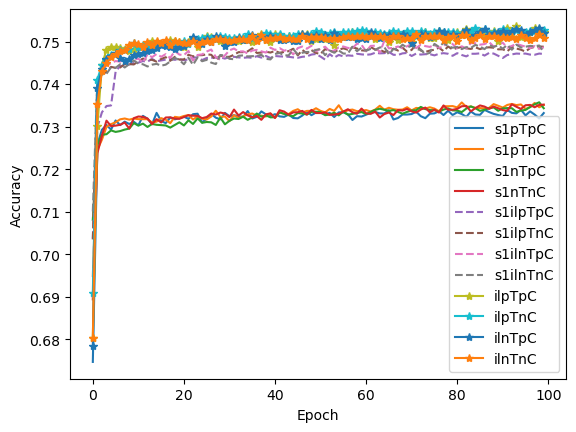

In [56]:
# DF abbreviations:
# s1pTpC, s1pTnC, s1nTpC, s1nTnC
# s1ilpTpC, s1ilpTnC, s1ilnTpC, s1ilnTnC
# ilpTpC, ilpTnC, ilnTpC, ilnTnC

plt.plot(range(len(fit_s1pTpC.history["accuracy"])), fit_s1pTpC.history["accuracy"], label="s1pTpC")
plt.plot(range(len(fit_s1pTnC.history["accuracy"])), fit_s1pTnC.history["accuracy"], label="s1pTnC")
plt.plot(range(len(fit_s1nTpC.history["accuracy"])), fit_s1nTpC.history["accuracy"], label="s1nTpC")
plt.plot(range(len(fit_s1nTnC.history["accuracy"])), fit_s1nTnC.history["accuracy"], label="s1nTnC")

plt.plot(range(len(fit_s1ilpTpC.history["accuracy"])), fit_s1ilpTpC.history["accuracy"], label="s1ilpTpC", ls="--")
plt.plot(range(len(fit_s1ilpTnC.history["accuracy"])), fit_s1ilpTnC.history["accuracy"], label="s1ilpTnC", ls="--")
plt.plot(range(len(fit_s1ilnTpC.history["accuracy"])), fit_s1ilnTpC.history["accuracy"], label="s1ilnTpC", ls="--")
plt.plot(range(len(fit_s1ilnTnC.history["accuracy"])), fit_s1ilnTnC.history["accuracy"], label="s1ilnTnC", ls="--")

plt.plot(range(len(fit_ilpTpC.history["accuracy"])), fit_ilpTpC.history["accuracy"], label="ilpTpC", marker="*")
plt.plot(range(len(fit_ilpTnC.history["accuracy"])), fit_ilpTnC.history["accuracy"], label="ilpTnC", marker="*")
plt.plot(range(len(fit_ilnTpC.history["accuracy"])), fit_ilnTpC.history["accuracy"], label="ilnTpC", marker="*")
plt.plot(range(len(fit_ilnTnC.history["accuracy"])), fit_ilnTnC.history["accuracy"], label="ilnTnC", marker="*")

plt.legend()
#plt.ylim(0.73, 0.755)
#plt.ylim(0.743, 0.755)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [52]:
# DF abbreviations:
# s1pTpC, s1pTnC, s1nTpC, s1nTnC
# s1ilpTpC, s1ilpTnC, s1ilnTpC, s1ilnTnC
# ilpTpC, ilpTnC, ilnTpC, ilnTnC

# test the models


loss_s1pTpC, accuracy_s1pTpC = nn_s1pTpC.evaluate(X_tes_s1pTpC,y_te_s1pTpC,verbose=2)
loss_s1pTnC, accuracy_s1pTnC = nn_s1pTnC.evaluate(X_tes_s1pTnC,y_te_s1pTnC,verbose=2)
loss_s1nTpC, accuracy_s1nTpC = nn_s1nTpC.evaluate(X_tes_s1nTpC,y_te_s1nTpC,verbose=2)
loss_s1nTnC, accuracy_s1nTnC = nn_s1nTnC.evaluate(X_tes_s1nTnC,y_te_s1nTnC,verbose=2)

loss_s1ilpTpC, accuracy_s1ilpTpC = nn_s1ilpTpC.evaluate(X_tes_s1ilpTpC,y_te_s1ilpTpC,verbose=2)
loss_s1ilpTnC, accuracy_s1ilpTnC = nn_s1ilpTnC.evaluate(X_tes_s1ilpTnC,y_te_s1ilpTnC,verbose=2)
loss_s1ilnTpC, accuracy_s1ilnTpC = nn_s1ilnTpC.evaluate(X_tes_s1ilnTpC,y_te_s1ilnTpC,verbose=2)
loss_s1ilnTnC, accuracy_s1ilnTnC = nn_s1ilnTnC.evaluate(X_tes_s1ilnTnC,y_te_s1ilnTnC,verbose=2)

loss_ilpTpC, accuracy_ilpTpC = nn_ilpTpC.evaluate(X_tes_ilpTpC,y_te_ilpTpC,verbose=2)
loss_ilpTnC, accuracy_ilpTnC = nn_ilpTnC.evaluate(X_tes_ilpTnC,y_te_ilpTnC,verbose=2)
loss_ilnTpC, accuracy_ilnTpC = nn_ilnTpC.evaluate(X_tes_ilnTpC,y_te_ilnTpC,verbose=2)
loss_ilnTnC, accuracy_ilnTnC = nn_ilnTnC.evaluate(X_tes_ilnTnC,y_te_ilnTnC,verbose=2)

print("\n")

print(f"s1, prevT, prevC: Loss: {loss_s1pTpC:.3f}, Accuracy: {accuracy_s1pTpC:.4f}")
print(f"s1, prevT, newC: Loss: {loss_s1pTnC:.3f}, Accuracy: {accuracy_s1pTnC:.4f}")
print(f"s1, newT, prevC: Loss: {loss_s1nTpC:.3f}, Accuracy: {accuracy_s1nTpC:.4f}")
print(f"s1, newT, newC: Loss: {loss_s1nTnC:.3f}, Accuracy: {accuracy_s1nTnC:.4f}")
print("\n")
print(f"s1, inliers, prevT, prevC: Loss: {loss_s1ilpTpC:.3f}, Accuracy: {accuracy_s1ilpTpC:.4f}")
print(f"s1, inliers, prevT, newC: Loss: {loss_s1ilpTnC:.3f}, Accuracy: {accuracy_s1ilpTnC:.4f}")
print(f"s1, inliers, newT, prevC: Loss: {loss_s1ilnTpC:.3f}, Accuracy: {accuracy_s1ilnTpC:.4f}")
print(f"s1, inliers, newT, newC: Loss: {loss_s1ilnTnC:.3f}, Accuracy: {accuracy_s1ilnTnC:.4f}")
print("\n")
print(f"inliers, prevT, prevC: Loss: {loss_ilpTpC:.3f}, Accuracy: {accuracy_ilpTpC:.4f}")
print(f"inliers, prevT, newC: Loss: {loss_ilpTnC:.3f}, Accuracy: {accuracy_ilpTnC:.4f}")
print(f"inliers, newT, prevC: Loss: {loss_ilnTpC:.3f}, Accuracy: {accuracy_ilnTpC:.4f}")
print(f"inliers, newT, newC: Loss: {loss_ilnTnC:.3f}, Accuracy: {accuracy_ilnTnC:.4f}")

268/268 - 0s - loss: 0.5603 - accuracy: 0.7270 - 257ms/epoch - 958us/step
268/268 - 0s - loss: 0.5590 - accuracy: 0.7246 - 254ms/epoch - 946us/step
268/268 - 0s - loss: 0.5622 - accuracy: 0.7259 - 302ms/epoch - 1ms/step
268/268 - 0s - loss: 0.5628 - accuracy: 0.7260 - 349ms/epoch - 1ms/step
220/220 - 0s - loss: 0.5422 - accuracy: 0.7424 - 312ms/epoch - 1ms/step
220/220 - 0s - loss: 0.5415 - accuracy: 0.7478 - 333ms/epoch - 2ms/step
220/220 - 0s - loss: 0.5407 - accuracy: 0.7471 - 234ms/epoch - 1ms/step
220/220 - 0s - loss: 0.5414 - accuracy: 0.7458 - 214ms/epoch - 974us/step
220/220 - 0s - loss: 0.5523 - accuracy: 0.7346 - 207ms/epoch - 943us/step
220/220 - 0s - loss: 0.5494 - accuracy: 0.7382 - 210ms/epoch - 952us/step
220/220 - 0s - loss: 0.5489 - accuracy: 0.7376 - 211ms/epoch - 960us/step
220/220 - 0s - loss: 0.5508 - accuracy: 0.7351 - 206ms/epoch - 936us/step


s1, prevT, prevC: Loss: 0.560, Accuracy: 0.7270
s1, prevT, newC: Loss: 0.559, Accuracy: 0.7246
s1, newT, prevC: Loss: 0.

In [57]:
# Clearly, getting rid of the outliers in the asking amount had the biggest effect
# beyond that, getting rid of the 5 status=0 had maybe a marginal effect
# then, the changes between the new binning for the application types and classifications had the least effect

# in the training data, inliers without step1 did the best
# in the testing data, inliers with step1 did the best
# take 1 of each and explore adding more nodes
# choose s1ilpTnC -- step1, inliers, prevT binning, newC binning
#    and ilpTnC -- inliers, prevT binning, newC binning

# Another sequential model
# first layer: number of features * 3
# second layer: int(number of features * 1.5)
# keep relu activations

# s1ilpTnC
n_s1ilpTnC = X_trs_s1ilpTnC.shape[1]
nnv2_s1ilpTnC = tf.keras.models.Sequential()
nnv2_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, input_dim=n_s1ilpTnC, activation="relu")) # First hidden layer
nnv2_s1ilpTnC.add(tf.keras.layers.Dense(units=int(n_s1ilpTnC*1.5), activation="relu")) # Second hidden layer
nnv2_s1ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv2_s1ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv2_s1ilpTnC.summary())

# ilpTnC
n_ilpTnC = X_trs_ilpTnC.shape[1]
nnv2_ilpTnC = tf.keras.models.Sequential()
nnv2_ilpTnC.add(tf.keras.layers.Dense(units=n_ilpTnC*3, input_dim=n_ilpTnC, activation="relu")) # First hidden layer
nnv2_ilpTnC.add(tf.keras.layers.Dense(units=int(n_ilpTnC*1.5), activation="relu")) # Second hidden layer
nnv2_ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv2_ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv2_ilpTnC.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 123)               5166      
                                                                 
 dense_37 (Dense)            (None, 61)                7564      
                                                                 
 dense_38 (Dense)            (None, 1)                 62        
                                                                 
Total params: 12,792
Trainable params: 12,792
Non-trainable params: 0
_________________________________________________________________


None

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 126)               5418      
                                                                 
 dense_40 (Dense)            (None, 63)                8001      
                                                                 
 dense_41 (Dense)            (None, 1)                 64        
                                                                 
Total params: 13,483
Trainable params: 13,483
Non-trainable params: 0
_________________________________________________________________


None

In [58]:
# train the 2 new models

# s1ilpTnC
print("-------v2: s1 inliers prevT newC ----------")
fitv2_s1ilpTnC = nnv2_s1ilpTnC.fit(X_trs_s1ilpTnC, y_tr_s1ilpTnC, epochs=100)
print("------------------------------------")

# ilpTnC
print("-------v2: inliers prevT newC ----------")
fitv2_ilpTnC = nnv2_ilpTnC.fit(X_trs_ilpTnC, y_tr_ilpTnC, epochs=100)
print("------------------------------------")


-------v2: s1 inliers prevT newC ----------
Epoch 1/100
660/660 [==============================] - 2s 2ms/step - loss: 0.5592 - accuracy: 0.7384
Epoch 2/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5465 - accuracy: 0.7440
Epoch 3/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5419 - accuracy: 0.7455
Epoch 4/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5406 - accuracy: 0.7450
Epoch 5/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5386 - accuracy: 0.7470
Epoch 6/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5382 - accuracy: 0.7470
Epoch 7/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5370 - accuracy: 0.7480
Epoch 8/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5366 - accuracy: 0.7488
Epoch 9/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5354 - accuracy: 0.7483
Epoch 10/100
660/660 [=========================

Epoch 81/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5264 - accuracy: 0.7545
Epoch 82/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5235 - accuracy: 0.7544
Epoch 83/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5232 - accuracy: 0.7543
Epoch 84/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5234 - accuracy: 0.7545
Epoch 85/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5233 - accuracy: 0.7541
Epoch 86/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5236 - accuracy: 0.7537
Epoch 87/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5232 - accuracy: 0.7546
Epoch 88/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5229 - accuracy: 0.7549
Epoch 89/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5235 - accuracy: 0.7547
Epoch 90/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5233

660/660 [==============================] - 1s 1ms/step - loss: 0.5230 - accuracy: 0.7567
Epoch 61/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5220 - accuracy: 0.7574
Epoch 62/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5224 - accuracy: 0.7569
Epoch 63/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5226 - accuracy: 0.7570
Epoch 64/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5220 - accuracy: 0.7567
Epoch 65/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5214 - accuracy: 0.7570
Epoch 66/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5227 - accuracy: 0.7570
Epoch 67/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5215 - accuracy: 0.7567
Epoch 68/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5214 - accuracy: 0.7574
Epoch 69/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5215 - accuracy: 

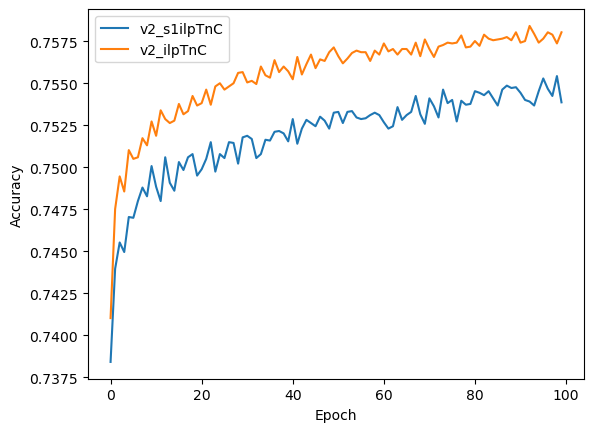

In [63]:
# another training accuracy plot

plt.plot(range(len(fitv2_s1ilpTnC.history["accuracy"])), fitv2_s1ilpTnC.history["accuracy"], label="v2_s1ilpTnC")
plt.plot(range(len(fitv2_ilpTnC.history["accuracy"])), fitv2_ilpTnC.history["accuracy"], label="v2_ilpTnC")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.ylim(0.747, 0.76)
plt.show()

In [61]:
# evaluate the models

lossv2_s1ilpTnC, accuracyv2_s1ilpTnC = nnv2_s1ilpTnC.evaluate(X_tes_s1ilpTnC,y_te_s1ilpTnC,verbose=2)
lossv2_ilpTnC, accuracyv2_ilpTnC = nnv2_ilpTnC.evaluate(X_tes_ilpTnC,y_te_ilpTnC,verbose=2)
print("\n")
print(f"v1: s1, inliers, prevT, newC: Loss: {loss_s1ilpTnC:.3f}, Accuracy: {accuracy_s1ilpTnC:.4f}")
print(f"v2: s1, inliers, prevT, newC: Loss: {lossv2_s1ilpTnC:.3f}, Accuracy: {accuracyv2_s1ilpTnC:.4f}")
print(f"v1: inliers, prevT, newC: Loss: {loss_ilpTnC:.3f}, Accuracy: {accuracy_ilpTnC:.4f}")
print(f"v2: inliers, prevT, newC: Loss: {lossv2_ilpTnC:.3f}, Accuracy: {accuracyv2_ilpTnC:.4f}")

220/220 - 0s - loss: 0.5422 - accuracy: 0.7467 - 219ms/epoch - 996us/step
220/220 - 0s - loss: 0.5756 - accuracy: 0.7363 - 212ms/epoch - 964us/step


v1: s1, inliers, prevT, newC: Loss: 0.541, Accuracy: 0.7478
v2: s1, inliers, prevT, newC: Loss: 0.542, Accuracy: 0.7467
v1: inliers, prevT, newC: Loss: 0.549, Accuracy: 0.7382
v2: inliers, prevT, newC: Loss: 0.576, Accuracy: 0.7363


In [64]:
# increasing the number of neurons made it worse, though not too significantly

# try it one last time, lots of neurons again, but use tanh for the activation functions on both layers

# s1ilpTnC
n_s1ilpTnC = X_trs_s1ilpTnC.shape[1]
nnv3_s1ilpTnC = tf.keras.models.Sequential()
nnv3_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, input_dim=n_s1ilpTnC, activation="tanh")) # First hidden layer
nnv3_s1ilpTnC.add(tf.keras.layers.Dense(units=int(n_s1ilpTnC*1.5), activation="tanh")) # Second hidden layer
nnv3_s1ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv3_s1ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv3_s1ilpTnC.summary())

# ilpTnC
n_ilpTnC = X_trs_ilpTnC.shape[1]
nnv3_ilpTnC = tf.keras.models.Sequential()
nnv3_ilpTnC.add(tf.keras.layers.Dense(units=n_ilpTnC*3, input_dim=n_ilpTnC, activation="tanh")) # First hidden layer
nnv3_ilpTnC.add(tf.keras.layers.Dense(units=int(n_ilpTnC*1.5), activation="tanh")) # Second hidden layer
nnv3_ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv3_ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv3_ilpTnC.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 123)               5166      
                                                                 
 dense_43 (Dense)            (None, 61)                7564      
                                                                 
 dense_44 (Dense)            (None, 1)                 62        
                                                                 
Total params: 12,792
Trainable params: 12,792
Non-trainable params: 0
_________________________________________________________________


None

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 126)               5418      
                                                                 
 dense_46 (Dense)            (None, 63)                8001      
                                                                 
 dense_47 (Dense)            (None, 1)                 64        
                                                                 
Total params: 13,483
Trainable params: 13,483
Non-trainable params: 0
_________________________________________________________________


None

In [65]:
# train the 2 new models

# s1ilpTnC
print("-------v3: s1 inliers prevT newC ----------")
fitv3_s1ilpTnC = nnv3_s1ilpTnC.fit(X_trs_s1ilpTnC, y_tr_s1ilpTnC, epochs=100)
print("------------------------------------")

# ilpTnC
print("-------v3: inliers prevT newC ----------")
fitv3_ilpTnC = nnv3_ilpTnC.fit(X_trs_ilpTnC, y_tr_ilpTnC, epochs=100)
print("------------------------------------")


-------v3: s1 inliers prevT newC ----------
Epoch 1/100
660/660 [==============================] - 2s 2ms/step - loss: 0.5627 - accuracy: 0.7358
Epoch 2/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5469 - accuracy: 0.7433
Epoch 3/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.7456
Epoch 4/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5413 - accuracy: 0.7446
Epoch 5/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5400 - accuracy: 0.7459
Epoch 6/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5393 - accuracy: 0.7468
Epoch 7/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5376 - accuracy: 0.7468
Epoch 8/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5376 - accuracy: 0.7466
Epoch 9/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5364 - accuracy: 0.7477
Epoch 10/100
660/660 [=========================

Epoch 81/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5209 - accuracy: 0.7541
Epoch 82/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5207 - accuracy: 0.7545
Epoch 83/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5209 - accuracy: 0.7551
Epoch 84/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5203 - accuracy: 0.7543
Epoch 85/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5208 - accuracy: 0.7543
Epoch 86/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5207 - accuracy: 0.7550
Epoch 87/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5205 - accuracy: 0.7548
Epoch 88/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5207 - accuracy: 0.7546
Epoch 89/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5203 - accuracy: 0.7543
Epoch 90/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5203

660/660 [==============================] - 1s 1ms/step - loss: 0.5198 - accuracy: 0.7586
Epoch 61/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5192 - accuracy: 0.7570
Epoch 62/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5192 - accuracy: 0.7577
Epoch 63/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5191 - accuracy: 0.7572
Epoch 64/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5189 - accuracy: 0.7570
Epoch 65/100
660/660 [==============================] - 1s 1ms/step - loss: 0.5191 - accuracy: 0.7571
Epoch 66/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5188 - accuracy: 0.7575
Epoch 67/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5186 - accuracy: 0.7583
Epoch 68/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5184 - accuracy: 0.7579
Epoch 69/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5190 - accuracy: 

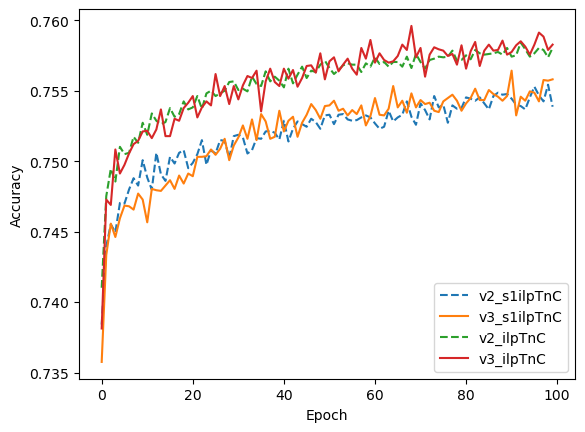

In [67]:
# another training accuracy plot

plt.plot(range(len(fitv2_s1ilpTnC.history["accuracy"])), fitv2_s1ilpTnC.history["accuracy"], label="v2_s1ilpTnC", ls="--")
plt.plot(range(len(fitv3_s1ilpTnC.history["accuracy"])), fitv3_s1ilpTnC.history["accuracy"], label="v3_s1ilpTnC")
plt.plot(range(len(fitv2_ilpTnC.history["accuracy"])), fitv2_ilpTnC.history["accuracy"], label="v2_ilpTnC", ls="--")
plt.plot(range(len(fitv3_ilpTnC.history["accuracy"])), fitv3_ilpTnC.history["accuracy"], label="v3_ilpTnC")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.ylim(0.747, 0.763)
plt.show()

In [68]:
# evaluate the models

lossv3_s1ilpTnC, accuracyv3_s1ilpTnC = nnv3_s1ilpTnC.evaluate(X_tes_s1ilpTnC,y_te_s1ilpTnC,verbose=2)
lossv3_ilpTnC, accuracyv3_ilpTnC = nnv3_ilpTnC.evaluate(X_tes_ilpTnC,y_te_ilpTnC,verbose=2)

print("\n")
print(f"v1: s1, inliers, prevT, newC: Loss: {loss_s1ilpTnC:.3f}, Accuracy: {accuracy_s1ilpTnC:.4f}")
print(f"v2: s1, inliers, prevT, newC: Loss: {lossv2_s1ilpTnC:.3f}, Accuracy: {accuracyv2_s1ilpTnC:.4f}")
print(f"v3: s1, inliers, prevT, newC: Loss: {lossv3_s1ilpTnC:.3f}, Accuracy: {accuracyv3_s1ilpTnC:.4f}")
print("\n")
print(f"v1: inliers, prevT, newC: Loss: {loss_ilpTnC:.3f}, Accuracy: {accuracy_ilpTnC:.4f}")
print(f"v2: inliers, prevT, newC: Loss: {lossv2_ilpTnC:.3f}, Accuracy: {accuracyv2_ilpTnC:.4f}")
print(f"v3: inliers, prevT, newC: Loss: {lossv3_ilpTnC:.3f}, Accuracy: {accuracyv3_ilpTnC:.4f}")

220/220 - 0s - loss: 0.5430 - accuracy: 0.7453 - 322ms/epoch - 1ms/step
220/220 - 0s - loss: 0.5632 - accuracy: 0.7366 - 302ms/epoch - 1ms/step


v1: s1, inliers, prevT, newC: Loss: 0.541, Accuracy: 0.7478
v2: s1, inliers, prevT, newC: Loss: 0.542, Accuracy: 0.7467
v3: s1, inliers, prevT, newC: Loss: 0.543, Accuracy: 0.7453


v1: inliers, prevT, newC: Loss: 0.549, Accuracy: 0.7382
v2: inliers, prevT, newC: Loss: 0.576, Accuracy: 0.7363
v3: inliers, prevT, newC: Loss: 0.563, Accuracy: 0.7366


In [69]:
# ok, one last time, promise
# 3rd hidden layer
# 3rd hidden layer will be int(number of features * 0.667)
# 1st, 2nd layers: tanh
# 3rd layer: relu

# s1ilpTnC
n_s1ilpTnC = X_trs_s1ilpTnC.shape[1]
nnv4_s1ilpTnC = tf.keras.models.Sequential()
nnv4_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, input_dim=n_s1ilpTnC, activation="tanh")) # First hidden layer
nnv4_s1ilpTnC.add(tf.keras.layers.Dense(units=int(n_s1ilpTnC*1.5), activation="tanh")) # Second hidden layer
nnv4_s1ilpTnC.add(tf.keras.layers.Dense(units=int(n_s1ilpTnC*0.667), activation="relu")) # Third hidden layer
nnv4_s1ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv4_s1ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv4_s1ilpTnC.summary())

# ilpTnC
n_ilpTnC = X_trs_ilpTnC.shape[1]
nnv4_ilpTnC = tf.keras.models.Sequential()
nnv4_ilpTnC.add(tf.keras.layers.Dense(units=n_ilpTnC*3, input_dim=n_ilpTnC, activation="tanh")) # First hidden layer
nnv4_ilpTnC.add(tf.keras.layers.Dense(units=int(n_ilpTnC*1.5), activation="tanh")) # Second hidden layer
nnv4_ilpTnC.add(tf.keras.layers.Dense(units=int(n_ilpTnC*0.667), activation="relu")) # Third hidden layer
nnv4_ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv4_ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv4_ilpTnC.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 123)               5166      
                                                                 
 dense_49 (Dense)            (None, 61)                7564      
                                                                 
 dense_50 (Dense)            (None, 27)                1674      
                                                                 
 dense_51 (Dense)            (None, 1)                 28        
                                                                 
Total params: 14,432
Trainable params: 14,432
Non-trainable params: 0
_________________________________________________________________


None

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 126)               5418      
                                                                 
 dense_53 (Dense)            (None, 63)                8001      
                                                                 
 dense_54 (Dense)            (None, 28)                1792      
                                                                 
 dense_55 (Dense)            (None, 1)                 29        
                                                                 
Total params: 15,240
Trainable params: 15,240
Non-trainable params: 0
_________________________________________________________________


None

In [70]:
# train the 2 new models
# increase number of epochs slightly

# s1ilpTnC
print("-------v4: s1 inliers prevT newC ----------")
fitv4_s1ilpTnC = nnv4_s1ilpTnC.fit(X_trs_s1ilpTnC, y_tr_s1ilpTnC, epochs=133)
print("------------------------------------")

# ilpTnC
print("-------v4: inliers prevT newC ----------")
fitv4_ilpTnC = nnv4_ilpTnC.fit(X_trs_ilpTnC, y_tr_ilpTnC, epochs=133)
print("------------------------------------")


-------v4: s1 inliers prevT newC ----------
Epoch 1/133
660/660 [==============================] - 2s 2ms/step - loss: 0.5572 - accuracy: 0.7348
Epoch 2/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5456 - accuracy: 0.7449
Epoch 3/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5432 - accuracy: 0.7442
Epoch 4/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5409 - accuracy: 0.7457
Epoch 5/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5394 - accuracy: 0.7465
Epoch 6/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5391 - accuracy: 0.7463
Epoch 7/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5375 - accuracy: 0.7479
Epoch 8/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5371 - accuracy: 0.7483
Epoch 9/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5367 - accuracy: 0.7483
Epoch 10/133
660/660 [=========================

Epoch 81/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5205 - accuracy: 0.7551
Epoch 82/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5201 - accuracy: 0.7554
Epoch 83/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5200 - accuracy: 0.7554
Epoch 84/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5203 - accuracy: 0.7557
Epoch 85/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5204 - accuracy: 0.7551
Epoch 86/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5196 - accuracy: 0.7555
Epoch 87/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5196 - accuracy: 0.7553
Epoch 88/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5195 - accuracy: 0.7559
Epoch 89/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5194 - accuracy: 0.7560
Epoch 90/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5196

660/660 [==============================] - 1s 2ms/step - loss: 0.5250 - accuracy: 0.7560
Epoch 28/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5243 - accuracy: 0.7563
Epoch 29/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5243 - accuracy: 0.7560
Epoch 30/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5240 - accuracy: 0.7559
Epoch 31/133
660/660 [==============================] - 1s 1ms/step - loss: 0.5237 - accuracy: 0.7563
Epoch 32/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7564
Epoch 33/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5231 - accuracy: 0.7565
Epoch 34/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5229 - accuracy: 0.7570
Epoch 35/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5226 - accuracy: 0.7569
Epoch 36/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5220 - accuracy: 

660/660 [==============================] - 1s 2ms/step - loss: 0.5137 - accuracy: 0.7598
Epoch 108/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5136 - accuracy: 0.7598
Epoch 109/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5135 - accuracy: 0.7600
Epoch 110/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5133 - accuracy: 0.7601
Epoch 111/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5136 - accuracy: 0.7602
Epoch 112/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5136 - accuracy: 0.7601
Epoch 113/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5136 - accuracy: 0.7599
Epoch 114/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5136 - accuracy: 0.7597
Epoch 115/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5136 - accuracy: 0.7599
Epoch 116/133
660/660 [==============================] - 1s 2ms/step - loss: 0.5131 - a

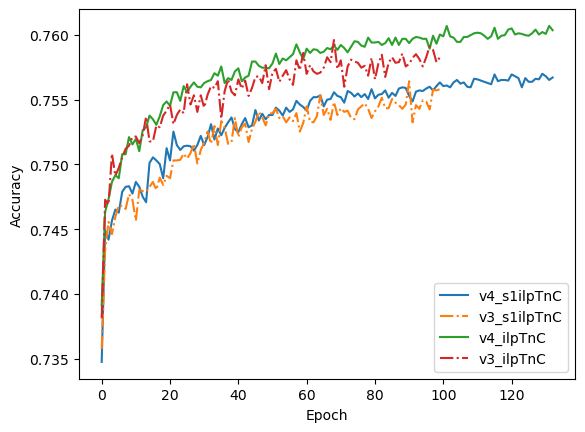

In [71]:
# another training accuracy plot

plt.plot(range(len(fitv4_s1ilpTnC.history["accuracy"])), fitv4_s1ilpTnC.history["accuracy"], label="v4_s1ilpTnC")
plt.plot(range(len(fitv3_s1ilpTnC.history["accuracy"])), fitv3_s1ilpTnC.history["accuracy"], label="v3_s1ilpTnC", ls="-.")
plt.plot(range(len(fitv4_ilpTnC.history["accuracy"])), fitv4_ilpTnC.history["accuracy"], label="v4_ilpTnC")
plt.plot(range(len(fitv3_ilpTnC.history["accuracy"])), fitv3_ilpTnC.history["accuracy"], label="v3_ilpTnC", ls="-.")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.ylim(0.747, 0.763)
plt.show()

In [72]:
# evaluate the models

lossv4_s1ilpTnC, accuracyv4_s1ilpTnC = nnv4_s1ilpTnC.evaluate(X_tes_s1ilpTnC,y_te_s1ilpTnC,verbose=2)
lossv4_ilpTnC, accuracyv4_ilpTnC = nnv4_ilpTnC.evaluate(X_tes_ilpTnC,y_te_ilpTnC,verbose=2)

print("\n")
print(f"v1: s1, inliers, prevT, newC: Loss: {loss_s1ilpTnC:.3f}, Accuracy: {accuracy_s1ilpTnC:.4f}")
print(f"v2: s1, inliers, prevT, newC: Loss: {lossv2_s1ilpTnC:.3f}, Accuracy: {accuracyv2_s1ilpTnC:.4f}")
print(f"v3: s1, inliers, prevT, newC: Loss: {lossv3_s1ilpTnC:.3f}, Accuracy: {accuracyv3_s1ilpTnC:.4f}")
print(f"v4: s1, inliers, prevT, newC: Loss: {lossv4_s1ilpTnC:.3f}, Accuracy: {accuracyv4_s1ilpTnC:.4f}")
print("\n")
print(f"v1: inliers, prevT, newC: Loss: {loss_ilpTnC:.3f}, Accuracy: {accuracy_ilpTnC:.4f}")
print(f"v2: inliers, prevT, newC: Loss: {lossv2_ilpTnC:.3f}, Accuracy: {accuracyv2_ilpTnC:.4f}")
print(f"v3: inliers, prevT, newC: Loss: {lossv3_ilpTnC:.3f}, Accuracy: {accuracyv3_ilpTnC:.4f}")
print(f"v4: inliers, prevT, newC: Loss: {lossv4_ilpTnC:.3f}, Accuracy: {accuracyv4_ilpTnC:.4f}")

220/220 - 0s - loss: 0.5580 - accuracy: 0.7446 - 323ms/epoch - 1ms/step
220/220 - 0s - loss: 0.5867 - accuracy: 0.7351 - 314ms/epoch - 1ms/step


v1: s1, inliers, prevT, newC: Loss: 0.541, Accuracy: 0.7478
v2: s1, inliers, prevT, newC: Loss: 0.542, Accuracy: 0.7467
v3: s1, inliers, prevT, newC: Loss: 0.543, Accuracy: 0.7453
v4: s1, inliers, prevT, newC: Loss: 0.558, Accuracy: 0.7446


v1: inliers, prevT, newC: Loss: 0.549, Accuracy: 0.7382
v2: inliers, prevT, newC: Loss: 0.576, Accuracy: 0.7363
v3: inliers, prevT, newC: Loss: 0.563, Accuracy: 0.7366
v4: inliers, prevT, newC: Loss: 0.587, Accuracy: 0.7351


In [73]:
# i lied. 1 more. don't decrease the number of neurons on each layer 
# keep same tanh, tanh, relu schema

# s1ilpTnC
n_s1ilpTnC = X_trs_s1ilpTnC.shape[1]
nnv5_s1ilpTnC = tf.keras.models.Sequential()
nnv5_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, input_dim=n_s1ilpTnC, activation="tanh")) # First hidden layer
nnv5_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, activation="tanh")) # Second hidden layer
nnv5_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, activation="relu")) # Third hidden layer
nnv5_s1ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv5_s1ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv5_s1ilpTnC.summary())

# ilpTnC
n_ilpTnC = X_trs_ilpTnC.shape[1]
nnv5_ilpTnC = tf.keras.models.Sequential()
nnv5_ilpTnC.add(tf.keras.layers.Dense(units=n_ilpTnC*3, input_dim=n_ilpTnC, activation="tanh")) # First hidden layer
nnv5_ilpTnC.add(tf.keras.layers.Dense(units=n_ilpTnC*3, activation="tanh")) # Second hidden layer
nnv5_ilpTnC.add(tf.keras.layers.Dense(units=n_ilpTnC*3, activation="relu")) # Third hidden layer
nnv5_ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv5_ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv5_ilpTnC.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 123)               5166      
                                                                 
 dense_57 (Dense)            (None, 123)               15252     
                                                                 
 dense_58 (Dense)            (None, 123)               15252     
                                                                 
 dense_59 (Dense)            (None, 1)                 124       
                                                                 
Total params: 35,794
Trainable params: 35,794
Non-trainable params: 0
_________________________________________________________________


None

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 126)               5418      
                                                                 
 dense_61 (Dense)            (None, 126)               16002     
                                                                 
 dense_62 (Dense)            (None, 126)               16002     
                                                                 
 dense_63 (Dense)            (None, 1)                 127       
                                                                 
Total params: 37,549
Trainable params: 37,549
Non-trainable params: 0
_________________________________________________________________


None

In [75]:
# train the 2 new models
# go back to 100 epochs

# s1ilpTnC
print("-------v5: s1 inliers prevT newC ----------")
fitv5_s1ilpTnC = nnv5_s1ilpTnC.fit(X_trs_s1ilpTnC, y_tr_s1ilpTnC, epochs=100)
print("------------------------------------")

# ilpTnC
print("-------v5: inliers prevT newC ----------")
fitv5_ilpTnC = nnv5_ilpTnC.fit(X_trs_ilpTnC, y_tr_ilpTnC, epochs=100)
print("------------------------------------")


-------v5: s1 inliers prevT newC ----------
Epoch 1/100
660/660 [==============================] - 2s 2ms/step - loss: 0.5590 - accuracy: 0.7358
Epoch 2/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5488 - accuracy: 0.7404
Epoch 3/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5449 - accuracy: 0.7444
Epoch 4/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5423 - accuracy: 0.7444
Epoch 5/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5415 - accuracy: 0.7450
Epoch 6/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5401 - accuracy: 0.7473
Epoch 7/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5398 - accuracy: 0.7461
Epoch 8/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5389 - accuracy: 0.7458
Epoch 9/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5379 - accuracy: 0.7477
Epoch 10/100
660/660 [=========================

Epoch 81/100
660/660 [==============================] - 2s 3ms/step - loss: 0.5195 - accuracy: 0.7555
Epoch 82/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5188 - accuracy: 0.7557
Epoch 83/100
660/660 [==============================] - 2s 3ms/step - loss: 0.5190 - accuracy: 0.7560
Epoch 84/100
660/660 [==============================] - 2s 3ms/step - loss: 0.5188 - accuracy: 0.7557
Epoch 85/100
660/660 [==============================] - 2s 3ms/step - loss: 0.5192 - accuracy: 0.7558
Epoch 86/100
660/660 [==============================] - 2s 3ms/step - loss: 0.5184 - accuracy: 0.7555
Epoch 87/100
660/660 [==============================] - 2s 3ms/step - loss: 0.5181 - accuracy: 0.7556
Epoch 88/100
660/660 [==============================] - 2s 3ms/step - loss: 0.5193 - accuracy: 0.7563
Epoch 89/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5183 - accuracy: 0.7565
Epoch 90/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5180

660/660 [==============================] - 1s 2ms/step - loss: 0.5186 - accuracy: 0.7579
Epoch 61/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5193 - accuracy: 0.7576
Epoch 62/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5193 - accuracy: 0.7582
Epoch 63/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5182 - accuracy: 0.7583
Epoch 64/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5179 - accuracy: 0.7577
Epoch 65/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5181 - accuracy: 0.7577
Epoch 66/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5177 - accuracy: 0.7579
Epoch 67/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5175 - accuracy: 0.7581
Epoch 68/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5174 - accuracy: 0.7586
Epoch 69/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5179 - accuracy: 

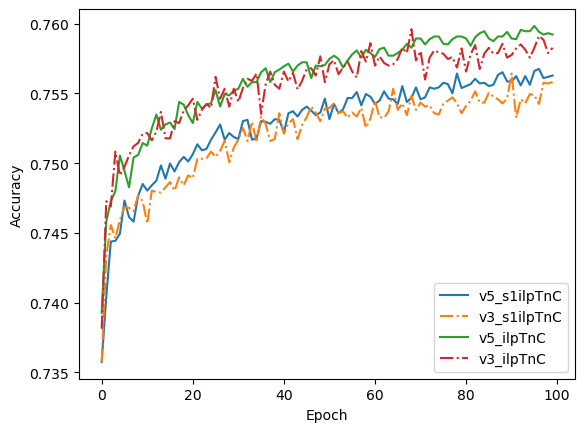

In [77]:
# another training accuracy plot

plt.plot(range(len(fitv5_s1ilpTnC.history["accuracy"])), fitv5_s1ilpTnC.history["accuracy"], label="v5_s1ilpTnC")
plt.plot(range(len(fitv3_s1ilpTnC.history["accuracy"])), fitv3_s1ilpTnC.history["accuracy"], label="v3_s1ilpTnC", ls="-.")
plt.plot(range(len(fitv5_ilpTnC.history["accuracy"])), fitv5_ilpTnC.history["accuracy"], label="v5_ilpTnC")
plt.plot(range(len(fitv3_ilpTnC.history["accuracy"])), fitv3_ilpTnC.history["accuracy"], label="v3_ilpTnC", ls="-.")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.ylim(0.747, 0.763)
plt.show()

In [78]:
# evaluate the models

lossv5_s1ilpTnC, accuracyv5_s1ilpTnC = nnv5_s1ilpTnC.evaluate(X_tes_s1ilpTnC,y_te_s1ilpTnC,verbose=2)
lossv5_ilpTnC, accuracyv5_ilpTnC = nnv5_ilpTnC.evaluate(X_tes_ilpTnC,y_te_ilpTnC,verbose=2)

print("\n")
print(f"v1: s1, inliers, prevT, newC: Loss: {loss_s1ilpTnC:.3f}, Accuracy: {accuracy_s1ilpTnC:.4f}")
print(f"v2: s1, inliers, prevT, newC: Loss: {lossv2_s1ilpTnC:.3f}, Accuracy: {accuracyv2_s1ilpTnC:.4f}")
print(f"v3: s1, inliers, prevT, newC: Loss: {lossv3_s1ilpTnC:.3f}, Accuracy: {accuracyv3_s1ilpTnC:.4f}")
print(f"v4: s1, inliers, prevT, newC: Loss: {lossv4_s1ilpTnC:.3f}, Accuracy: {accuracyv4_s1ilpTnC:.4f}")
print(f"v5: s1, inliers, prevT, newC: Loss: {lossv5_s1ilpTnC:.3f}, Accuracy: {accuracyv5_s1ilpTnC:.4f}")
print("\n")
print(f"v1: inliers, prevT, newC: Loss: {loss_ilpTnC:.3f}, Accuracy: {accuracy_ilpTnC:.4f}")
print(f"v2: inliers, prevT, newC: Loss: {lossv2_ilpTnC:.3f}, Accuracy: {accuracyv2_ilpTnC:.4f}")
print(f"v3: inliers, prevT, newC: Loss: {lossv3_ilpTnC:.3f}, Accuracy: {accuracyv3_ilpTnC:.4f}")
print(f"v4: inliers, prevT, newC: Loss: {lossv4_ilpTnC:.3f}, Accuracy: {accuracyv4_ilpTnC:.4f}")
print(f"v5: inliers, prevT, newC: Loss: {lossv5_ilpTnC:.3f}, Accuracy: {accuracyv5_ilpTnC:.4f}")

220/220 - 0s - loss: 0.5638 - accuracy: 0.7448 - 398ms/epoch - 2ms/step
220/220 - 0s - loss: 0.5848 - accuracy: 0.7365 - 406ms/epoch - 2ms/step


v1: s1, inliers, prevT, newC: Loss: 0.541, Accuracy: 0.7478
v2: s1, inliers, prevT, newC: Loss: 0.542, Accuracy: 0.7467
v3: s1, inliers, prevT, newC: Loss: 0.543, Accuracy: 0.7453
v4: s1, inliers, prevT, newC: Loss: 0.558, Accuracy: 0.7446
v5: s1, inliers, prevT, newC: Loss: 0.564, Accuracy: 0.7448


v1: inliers, prevT, newC: Loss: 0.549, Accuracy: 0.7382
v2: inliers, prevT, newC: Loss: 0.576, Accuracy: 0.7363
v3: inliers, prevT, newC: Loss: 0.563, Accuracy: 0.7366
v4: inliers, prevT, newC: Loss: 0.587, Accuracy: 0.7351
v5: inliers, prevT, newC: Loss: 0.585, Accuracy: 0.7365


In [79]:
# one more model because I haven't delivered on saving checkpoints yet


# choose s1ilpTnC since it performs best on testing data
# keep 3 layers
# keep high numbers of neurons in each layer
# switch all tanh to relu


# s1ilpTnC
n_s1ilpTnC = X_trs_s1ilpTnC.shape[1]
nnv6_s1ilpTnC = tf.keras.models.Sequential()
nnv6_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, input_dim=n_s1ilpTnC, activation="relu")) # First hidden layer
nnv6_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, activation="relu")) # Second hidden layer
nnv6_s1ilpTnC.add(tf.keras.layers.Dense(units=n_s1ilpTnC*3, activation="relu")) # Third hidden layer
nnv6_s1ilpTnC.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) # Output layer
nnv6_s1ilpTnC.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
display(nnv5_s1ilpTnC.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 123)               5166      
                                                                 
 dense_57 (Dense)            (None, 123)               15252     
                                                                 
 dense_58 (Dense)            (None, 123)               15252     
                                                                 
 dense_59 (Dense)            (None, 1)                 124       
                                                                 
Total params: 35,794
Trainable params: 35,794
Non-trainable params: 0
_________________________________________________________________


None

In [82]:
# Create checkpoint saving function
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimized/",exist_ok=True)
checkpoint_path = "checkpoints_optimized/weights_v6s1ilpTnC.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch', period=5)

In [83]:
# train the model, include checkpoint saving
# 100 epochs

# s1ilpTnC
print("-------v6: s1 inliers prevT newC ----------")
fitv6_s1ilpTnC = nnv6_s1ilpTnC.fit(X_trs_s1ilpTnC, y_tr_s1ilpTnC, epochs=100, callbacks=[cp_callback])
print("------------------------------------")

-------v6: s1 inliers prevT newC ----------
Epoch 1/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5306 - accuracy: 0.7507
Epoch 2/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5300 - accuracy: 0.7511
Epoch 3/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5302 - accuracy: 0.7516
Epoch 4/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5290 - accuracy: 0.7520
Epoch 5/100
659/660 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.7518
Epoch 5: saving model to checkpoints_optimized\weights_v6s1ilpTnC.05.hdf5
660/660 [==============================] - 1s 2ms/step - loss: 0.5292 - accuracy: 0.7518
Epoch 6/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.7522
Epoch 7/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5284 - accuracy: 0.7527
Epoch 8/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5285 - accura

660/660 [==============================] - 1s 2ms/step - loss: 0.5216 - accuracy: 0.7551
Epoch 63/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5238 - accuracy: 0.7550
Epoch 64/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5400 - accuracy: 0.7540
Epoch 65/100
643/660 [============================>.] - ETA: 0s - loss: 0.5366 - accuracy: 0.7545
Epoch 65: saving model to checkpoints_optimized\weights_v6s1ilpTnC.65.hdf5
660/660 [==============================] - 1s 2ms/step - loss: 0.5360 - accuracy: 0.7546
Epoch 66/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5213 - accuracy: 0.7547
Epoch 67/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5201 - accuracy: 0.7550
Epoch 68/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5198 - accuracy: 0.7555
Epoch 69/100
660/660 [==============================] - 1s 2ms/step - loss: 0.5197 - accuracy: 0.7555
Epoch 70/100
634/660 [===============

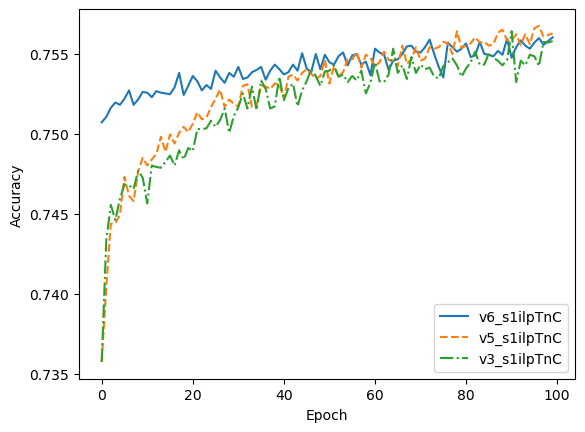

In [84]:
# another training accuracy plot

plt.plot(range(len(fitv6_s1ilpTnC.history["accuracy"])), fitv6_s1ilpTnC.history["accuracy"], label="v6_s1ilpTnC")
plt.plot(range(len(fitv5_s1ilpTnC.history["accuracy"])), fitv5_s1ilpTnC.history["accuracy"], label="v5_s1ilpTnC", ls="--")
plt.plot(range(len(fitv3_s1ilpTnC.history["accuracy"])), fitv3_s1ilpTnC.history["accuracy"], label="v3_s1ilpTnC", ls="-.")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.ylim(0.747, 0.763)
plt.show()

In [85]:
lossv6_s1ilpTnC, accuracyv6_s1ilpTnC = nnv6_s1ilpTnC.evaluate(X_tes_s1ilpTnC,y_te_s1ilpTnC,verbose=2)

print("\n")
print(f"v1: s1, inliers, prevT, newC: Loss: {loss_s1ilpTnC:.3f}, Accuracy: {accuracy_s1ilpTnC:.4f}")
print(f"v2: s1, inliers, prevT, newC: Loss: {lossv2_s1ilpTnC:.3f}, Accuracy: {accuracyv2_s1ilpTnC:.4f}")
print(f"v3: s1, inliers, prevT, newC: Loss: {lossv3_s1ilpTnC:.3f}, Accuracy: {accuracyv3_s1ilpTnC:.4f}")
print(f"v4: s1, inliers, prevT, newC: Loss: {lossv4_s1ilpTnC:.3f}, Accuracy: {accuracyv4_s1ilpTnC:.4f}")
print(f"v5: s1, inliers, prevT, newC: Loss: {lossv5_s1ilpTnC:.3f}, Accuracy: {accuracyv5_s1ilpTnC:.4f}")
print(f"v6: s1, inliers, prevT, newC: Loss: {lossv6_s1ilpTnC:.3f}, Accuracy: {accuracyv6_s1ilpTnC:.4f}")

220/220 - 0s - loss: 0.5694 - accuracy: 0.7461 - 327ms/epoch - 1ms/step


v1: s1, inliers, prevT, newC: Loss: 0.541, Accuracy: 0.7478
v2: s1, inliers, prevT, newC: Loss: 0.542, Accuracy: 0.7467
v3: s1, inliers, prevT, newC: Loss: 0.543, Accuracy: 0.7453
v4: s1, inliers, prevT, newC: Loss: 0.558, Accuracy: 0.7446
v5: s1, inliers, prevT, newC: Loss: 0.564, Accuracy: 0.7448
v6: s1, inliers, prevT, newC: Loss: 0.569, Accuracy: 0.7461


In [86]:
nnv6_s1ilpTnC.save("nnv6_s1ilpTnC_deliverable3.h5")